In [1]:
import pandas as pd

In [4]:
year = 2017

In [5]:
clustered = pd.read_csv("clustered_data_1_0.csv")
clustered

,traj,obs,old_traj,old_traj.1,longitude,latitude,cluster_id
0,0,0,4,40,-22.692282,16.033049,-1
1,0,1,4,40,-22.749298,16.032228,-1
2,0,2,4,40,-22.764538,16.034508,-1
3,0,3,4,40,-22.774569,16.018383,-1
4,0,4,4,40,-22.818733,15.991084,-1
...,...,...,...,...,...,...,...
178610,683,253,999,9964,-49.320366,10.847726,2
178611,683,254,999,9964,-49.505756,10.759947,2
178612,683,255,999,9964,-49.673706,10.700109,2
178613,683,256,999,9964,-49.828434,10.668164,2


In [20]:
cluster_ref_traj = (
    clustered[["cluster_id", "old_traj.1"]]
    .groupby("cluster_id").first()
    .iloc[:, 0].rename("traj")
    .drop(-1)
)
cluster_ref_traj

cluster_id
0     67
1    275
2     56
3    783
4    992
Name: traj, dtype: int64

In [6]:
from lagrangian_trajectory_clustering.data_loading import (
    load_cape_verde_trajectories,
    reindex_trajectories,
)

In [7]:
raw_data = load_cape_verde_trajectories(year=year)

display(raw_data)

time   latitude  longitude
traj obs                                 
0    0   1997-08-14  16.030224 -22.692162
     1   1997-08-15  16.017056 -22.714727
     2   1997-08-16  15.994600 -22.739052
     3   1997-08-17  15.954251 -22.766460
     4   1997-08-18  15.938750 -22.811235
...             ...        ...        ...
9999 248 1998-06-07   9.679025 -49.273670
     249 1998-06-08   9.653998 -49.456814
     250 1998-06-09   9.652131 -49.642100
     251 1998-06-10   9.651998 -49.820766
     252 1998-06-10   9.651998 -49.820766

[2967450 rows x 3 columns]

In [28]:
ref_trajs = raw_data.loc[cluster_ref_traj]
ref_trajs

time   latitude  longitude
traj obs                                 
67   0   1997-08-31  16.031120 -22.691238
     1   1997-09-01  16.023859 -22.708342
     2   1997-09-02  15.991339 -22.745426
     3   1997-09-03  15.961082 -22.793324
     4   1997-09-04  15.944976 -22.829826
...             ...        ...        ...
992  282 1998-06-23   9.812095 -49.508453
     283 1998-06-24   9.704523 -49.636528
     284 1998-06-25   9.600889 -49.762030
     285 1998-06-26   9.512796 -49.886562
     286 1998-06-26   9.512796 -49.886562

[1398 rows x 3 columns]

In [33]:
from matplotlib import pyplot as plt

CPU times: user 169 ms, sys: 67.2 ms, total: 236 ms
Wall time: 178 ms


traj
56     AxesSubplot(0.125,0.125;0.775x0.755)
67     AxesSubplot(0.125,0.125;0.775x0.755)
275    AxesSubplot(0.125,0.125;0.775x0.755)
783    AxesSubplot(0.125,0.125;0.775x0.755)
992    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

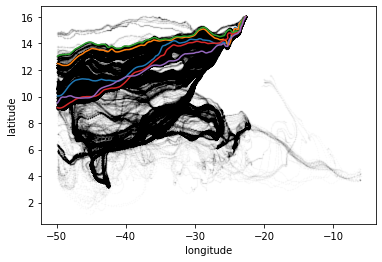

In [43]:
%%time

fig, ax = plt.subplots(1, 1)

raw_data.plot.scatter(x="longitude", y="latitude", s=1, alpha=0.01, color="black", ax=ax)
ref_trajs.groupby("traj").plot.line(x="longitude", y="latitude", ax=ax, legend=False);

In [44]:
from lagrangian_trajectory_clustering.trafo.grid import (
    geo_df_to_grid_series,  # lat lon coords to grid index
    grid_series_to_geo_df,  # grid index to lat lon coords
)

from lagrangian_trajectory_clustering.trafo.sequence import (
    remove_subsequent_identical_elements,  # transorm to sequence of unique subsequent elemets
    multi_index_series_to_series_sequences,  # transform to series of sequences
    series_sequences_to_multi_index_series,  # transform back from series of sequences
    fill_in_segments,  # fill in jumps leaping over grid boxes
)

In [45]:
lat_lon_res = 14

In [46]:
lat_num = int(180 // (abs(raw_data.latitude.max() - raw_data.latitude.min()) / lat_lon_res) + 1)
lon_num = int(360 // (abs(raw_data.longitude.max() - raw_data.longitude.min()) / lat_lon_res) + 1)
print(lon_num, lat_num)

115 170


In [48]:
%%time

raw_data_roundtrip = grid_series_to_geo_df(
    series_sequences_to_multi_index_series(
        fill_in_segments(
            remove_subsequent_identical_elements(
                multi_index_series_to_series_sequences(
                    geo_df_to_grid_series(
                        raw_data,
                        lon_num=lon_num,
                        lat_num=lat_num,
                    )
                )
            )
        )
    ),
    lon_num=lon_num,
    lat_num=lat_num,
)

display(raw_data_roundtrip)

/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


longitude   latitude
traj obs                       
0    0    336.315789  15.976331
     1    336.315789  14.911243
     2    336.315789  13.846154
     3    333.157895  13.846154
     4    333.157895  14.911243
...              ...        ...
9999 10   320.526316  10.650888
     11   317.368421  10.650888
     12   314.210526  10.650888
     13   311.052632  10.650888
     14   311.052632   9.585799

[187168 rows x 2 columns]

CPU times: user 7.48 s, sys: 149 ms, total: 7.63 s
Wall time: 7.63 s


In [49]:
sequential_data = fill_in_segments(
    remove_subsequent_identical_elements(
        multi_index_series_to_series_sequences(
            geo_df_to_grid_series(
                raw_data,
                lon_num=lon_num,
                lat_num=lat_num,
            )
        )
    )
)

display(sequential_data)

traj
0       [(106, 99), (106, 98), (106, 97), (105, 97), (...
1       [(106, 99), (106, 98), (106, 97), (105, 97), (...
2       [(106, 99), (106, 98), (105, 98), (105, 97), (...
3       [(106, 99), (106, 98), (105, 98), (105, 97), (...
4       [(106, 99), (106, 98), (105, 98), (104, 98), (...
                              ...                        
9995    [(106, 99), (106, 98), (106, 97), (105, 97), (...
9996    [(106, 99), (106, 98), (106, 97), (105, 97), (...
9997    [(106, 99), (106, 98), (106, 97), (105, 97), (...
9998    [(106, 99), (106, 98), (106, 97), (105, 97), (...
9999    [(106, 99), (106, 98), (106, 97), (105, 97), (...
Name: grid_index_lon_lat, Length: 10000, dtype: object

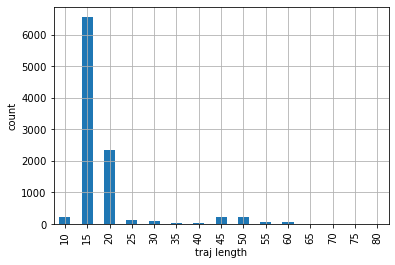

In [52]:
ax = sequential_data.apply(len).apply(lambda l: int(round(2 * l, -1) / 2)).value_counts().sort_index().plot.bar();
ax.grid()
ax.set_xlabel("traj length")
ax.set_ylabel("count");

In [53]:
sequential_data.apply(len).describe()

count    10000.000000
mean        18.716800
std          8.708971
min         11.000000
25%         15.000000
50%         16.000000
75%         18.000000
max         82.000000
Name: grid_index_lon_lat, dtype: float64

In [55]:
sequential_data_refs = sequential_data[cluster_ref_traj]
sequential_data_refs

traj
67     [(106, 99), (106, 98), (106, 97), (105, 97), (...
275    [(106, 99), (106, 98), (105, 98), (104, 98), (...
56     [(106, 99), (106, 98), (106, 97), (105, 97), (...
783    [(106, 99), (106, 98), (105, 98), (106, 98), (...
992    [(106, 99), (106, 98), (106, 97), (105, 97), (...
Name: grid_index_lon_lat, dtype: object

In [57]:
from lagrangian_trajectory_clustering.metrics import levenshtein_numpy_numba, lcs_numpy_numba
from lagrangian_trajectory_clustering.metrics_wrapped import wrapped_metric

In [56]:
import numpy as np

In [58]:
lcs_dist = lambda s0, s1: min(len(s0), len(s1)) / lcs_numpy_numba(s0, s1) - 1

In [60]:
%%time

dist_matrix = np.array(
    [
        sequential_data.apply(lambda s: lcs_dist(s, sequential_data_refs.iloc[n]))
        for n in range(len(sequential_data_refs))
    ]
)

CPU times: user 27.5 s, sys: 36.6 ms, total: 27.6 s
Wall time: 27.6 s


In [61]:
dist_matrix.shape

(5, 10000)

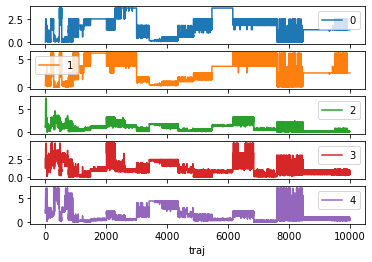

In [70]:
pd.DataFrame(dist_matrix.T, columns=cluster_ref_traj.index, index=sequential_data.index).plot(subplots=True);

traj
0       0
1       0
2       0
3       1
4       0
       ..
9995    2
9996    2
9997    2
9998    2
9999    2
Name: label, Length: 10000, dtype: int64

<AxesSubplot:ylabel='Frequency'>

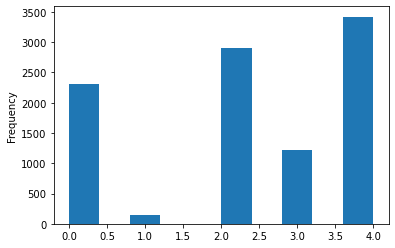

In [79]:
label = pd.Series(cluster_ref_traj.index[dist_matrix.argmin(axis=0)], index=sequential_data.index, name="label")
display(label)
label.plot.hist()

In [83]:
labeled_data = raw_data.join(label).reset_index().set_index(["label", "traj", "obs"])
labeled_data

time   latitude  longitude
label traj obs                                 
0     0    0   1997-08-14  16.030224 -22.692162
           1   1997-08-15  16.017056 -22.714727
           2   1997-08-16  15.994600 -22.739052
           3   1997-08-17  15.954251 -22.766460
           4   1997-08-18  15.938750 -22.811235
...                   ...        ...        ...
2     9999 248 1998-06-07   9.679025 -49.273670
           249 1998-06-08   9.653998 -49.456814
           250 1998-06-09   9.652131 -49.642100
           251 1998-06-10   9.651998 -49.820766
           252 1998-06-10   9.651998 -49.820766

[2967450 rows x 3 columns]

CPU times: user 294 ms, sys: 96.1 ms, total: 390 ms
Wall time: 300 ms


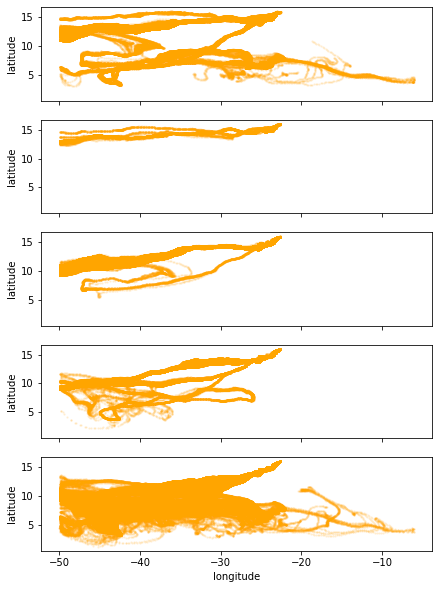

In [90]:
%%time

fig, ax = plt.subplots(
    len(sequential_data_refs), 1,
    figsize=(7, len(sequential_data_refs) * 2),
    sharex=True, sharey=True,
)
ax = ax.flatten()

for lab, _ax in zip(label.unique(), ax):

    labeled_data.loc[lab].plot.scatter(x="longitude", y="latitude", s=2, alpha=0.1, color="orange", ax=_ax);